# Fine-tuning
In this file we will fine-tune Encoder models, like BERET, RoBERTa, etc., on the corpus of PAN. Then, evaluate them on the test set.

In [1]:
import torch
from transformers import BertTokenizer, DataCollatorWithPadding, utils
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np
import os
import torchmetrics
from sklearn.metrics import f1_score
from bertviz import model_view
from datasets import Dataset
from bertviz import head_view
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy

from utilities import (read_paragraphs,
                       read_ground_truth, 
                       generate_dataset)
utils.logging.set_verbosity_error()  # Suppress standard warnings

In [2]:
# Due to the lack of the true test set. We use the validation set as our test set.
# We will split the training set into train and validation sets.
test_directory = './data/validation_processed'
test_label_directory = './data/validation_label'
checkpoint = "finetuned-bert-base-cased/sweep-1-checkpoint-225" 
device = torch.device('cuda' if torch.cuda.is_available() else  'cpu')
# File path to check
file_path = "classification_prob.npy"
file_exists = False
# Check if file exists
if os.path.isfile(file_path):
  file_exists = True
  print(f"File '{file_path}' exists.")
else:
  print(f"File '{file_path}' does not exist.")


File 'classification_prob.npy' exists.


In [3]:
# max(end_id) = 900
test_data = read_paragraphs(test_directory, start_id=1, end_id=900)
# Read ground truth labels
test_labels  = read_ground_truth(test_label_directory, start_id=1, end_id=900)

tokenizer = BertTokenizer.from_pretrained(checkpoint)
print(tokenizer.model_max_length)

test_dataset = generate_dataset(test_data, test_labels, tokenizer)

if not file_exists:
    def tokenize_function(example):
        return tokenizer(example["sentence1"], example["sentence2"], 
                        truncation=True)

    tokenized_datasets = test_dataset.map(tokenize_function, batched=True)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    print(tokenized_datasets)

512


In [4]:
if not file_exists:
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

In [5]:
if not file_exists:
    # Calculate classification logits
    batch_size=200
    class_logits = []
    model.to(device)
    with torch.no_grad():
        for batch in range(0, tokenized_datasets.num_rows, batch_size): # 
                input_ids = {k:v for k, v in tokenized_datasets[batch: batch + batch_size].items() if k not in ['sentence1', 'sentence2', 'idx']}
                batch_data = data_collator(input_ids)
                batch_data = {k:v.to(device) for k, v in batch_data.items()}
                outputs = model(**batch_data)
                print(outputs.keys(), outputs['logits'].shape)
                class_logits.append(outputs['logits'])
                # break

    concatenated_tensor = torch.cat(class_logits, dim=0)
    print(concatenated_tensor.shape)

In [6]:
if not file_exists:
    classification_prob = concatenated_tensor.detach().softmax(dim=1).cpu().numpy() # calculate classification probability
    # Save the ndarray to a file named "data.npy"
    np.save(file_path, classification_prob)
else:
    classification_prob = np.load(file_path)
    
print('F1-score:',f1_score(test_dataset['label'], np.argmax(classification_prob, axis=1).tolist(), average='macro', labels=[0, 1], zero_division=0))
print('Accuracy:', multiclass_accuracy(torch.tensor(np.argmax(classification_prob, axis=1)), torch.tensor(test_dataset['label']), num_classes=2, average="macro"))

target_prob_np = classification_prob[range(len(test_dataset['label'])), test_dataset['label']] # get the probabilities of true labels
target_prob_np.shape

F1-score: 0.7634547691955471
Accuracy: tensor(0.7609)


/home/shiling/anaconda3/lib/python3.11/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:232.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


(4592,)

In [7]:
sorted_idx = np.argsort(target_prob_np)[::-1]
target_prob_np[sorted_idx[-3:]], target_prob_np[sorted_idx[:3]]

(array([0.06674169, 0.06331286, 0.06158699], dtype=float32),
 array([0.98601574, 0.98601574, 0.98601574], dtype=float32))

In [8]:
for i in range(10):
    print(test_dataset['sentence1'][sorted_idx[i]])

In general , be courteous to others . Debate / discuss / argue the merits of ideas , don ' t attack people . Personal insults , shill or troll accusations , hate speech , any suggestion or support of harm , violence , or death , and other rule violations can result in a permanent ban .
In general , be courteous to others . Debate / discuss / argue the merits of ideas , don ' t attack people . Personal insults , shill or troll accusations , hate speech , any suggestion or support of harm , violence , or death , and other rule violations can result in a permanent ban .
In general , be courteous to others . Debate / discuss / argue the merits of ideas , don ' t attack people . Personal insults , shill or troll accusations , hate speech , any suggestion or support of harm , violence , or death , and other rule violations can result in a permanent ban .
In general , be courteous to others . Debate / discuss / argue the merits of ideas , don ' t attack people . Personal insults , shill or tr

In [9]:
# Remove duplicated samples。 Before: 4592 samples; After: 4030 samples
last_sentence1 = test_dataset['sentence1'][sorted_idx[0]]
last_sentence2 = test_dataset['sentence2'][sorted_idx[0]]
deduplicated_sorted_idx = [sorted_idx[0]]
for i in range(1, len(sorted_idx)):
    if not (test_dataset['sentence1'][sorted_idx[i]] == last_sentence1 and 
        test_dataset['sentence2'][sorted_idx[i]] == last_sentence2):
        last_sentence1 = test_dataset['sentence1'][sorted_idx[i]]
        last_sentence2 = test_dataset['sentence2'][sorted_idx[i]]
        deduplicated_sorted_idx.append(sorted_idx[i])
        
sorted_idx = deduplicated_sorted_idx
len(sorted_idx)

4030

In [10]:
for i in range(10):
    print('1:', test_dataset['sentence1'][sorted_idx[i]])
    print('2:', test_dataset['sentence2'][sorted_idx[i]])
    print()

1: In general , be courteous to others . Debate / discuss / argue the merits of ideas , don ' t attack people . Personal insults , shill or troll accusations , hate speech , any suggestion or support of harm , violence , or death , and other rule violations can result in a permanent ban .
2: For those who have questions regarding any media outlets being posted on this subreddit , please click to review our details as to our approved domains list and outlet criteria .

1: r / politics is currently accepting new moderator applications . If you want to help make this community a better place , consider !
2: In general , be courteous to others . Debate / discuss / argue the merits of ideas , don ' t attack people . Personal insults , shill or troll accusations , hate speech , any suggestion or support of harm , violence , or death , and other rule violations can result in a permanent ban .

1: I am a bot , and this action was performed automatically . Please if you have any questions or co

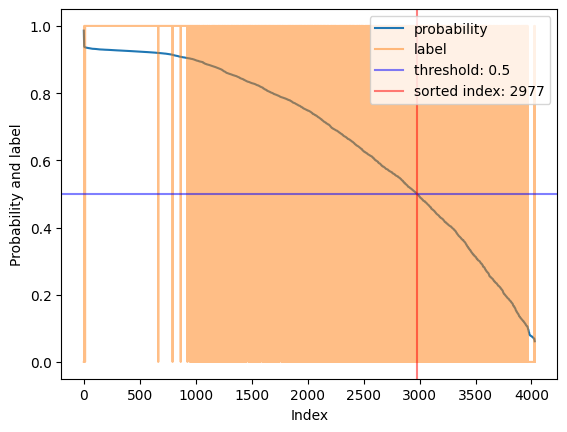

In [11]:
fig, ax = plt.subplots() 
ax.plot(target_prob_np[sorted_idx], label='probability') 
ax.plot(np.array(test_dataset['label'])[sorted_idx], alpha=0.5, label='label')

plt.axhline(0.5, color='blue',alpha=0.5, label='threshold: 0.5') # horizontal line, 水平线，alpha是指透明度
plt.axvline(2977, color='red',alpha=0.5, label='sorted index: 2977'); # vertical line, 垂直线，设置颜色

ax.set_xlabel('Index') 
ax.set_ylabel('Probability and label')
plt.legend(loc='upper right'); 
plt.show() 

# Attention visualization -- case study

In [12]:
# Enable returning attention scores
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, output_attentions=True)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
import matplotlib.pyplot as plt

def attention_views(text_idx, figsize=(10, 6)) :
    # input_texts = ["The cat sat on the mat" , "The cat sat on the mat" ]
    input_texts = [test_dataset['sentence1'][text_idx], test_dataset['sentence2'][text_idx]]
    label = test_dataset['label'][text_idx]
    print(f'True label: {label}, classification probability: {classification_prob[text_idx][label]}')
    print(input_texts[0])
    print(input_texts[1])
    inputs = tokenizer(input_texts[0], input_texts[1], return_tensors='pt')  # Tokenize input text
    inputs = {k:v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)  # Run model
    attention = outputs[-1][-1]  # Retrieve attention from model outputs, and select the attention of the last layer, torch.Size([1, 12, 8, 8])
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])  # Convert input ids to token strings
    # print(tokens)
    
    # Sample data (replace with your actual words and probabilities)
    words = tokens
    probabilities = torch.mean(attention[0,:,0,:], dim=0).cpu().detach().numpy()
    # print(probabilities)
    # Create the bar chart
    # How to make a plot with repeating labels on X axis? [duplicate]
    lab_x = [i for i in range(len(probabilities))]

    plt.figure(figsize=figsize)  # Adjust figure size as needed
    plt.bar(lab_x, probabilities, color='skyblue')
    plt.xticks(lab_x, words)

    # Set labels and title
    plt.xlabel("Tokens")
    plt.ylabel("Attention weights")
    plt.title("Attention view")

    # Rotate x-axis labels by 90 degrees (vertical orientation)
    plt.xticks(rotation=90)  # Simpler way to rotate 90 degrees vertically

    # Set grid for better visualization (optional)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

def head_views(text_idx) :
    # input_texts = ["The cat sat on the mat" , "The cat sat on the mat" ]
    input_texts = [test_dataset['sentence1'][text_idx], test_dataset['sentence2'][text_idx]]
    label = test_dataset['label'][text_idx]
    print(f'True label: {label}, classification probability: {classification_prob[text_idx][label]}')
    print(input_texts[0])
    print(input_texts[1])
    inputs = tokenizer(input_texts[0], input_texts[1], return_tensors='pt')  # Tokenize input text
    inputs = {k:v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)  # Run model
    attention = outputs[-1]  # Retrieve attention from model outputs
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])  # Convert input ids to token strings
    head_view(attention, tokens) 

## 1. The same author

True label: 0, classification probability: 0.9860157370567322
In general , be courteous to others . Debate / discuss / argue the merits of ideas , don ' t attack people . Personal insults , shill or troll accusations , hate speech , any suggestion or support of harm , violence , or death , and other rule violations can result in a permanent ban .
For those who have questions regarding any media outlets being posted on this subreddit , please click to review our details as to our approved domains list and outlet criteria .


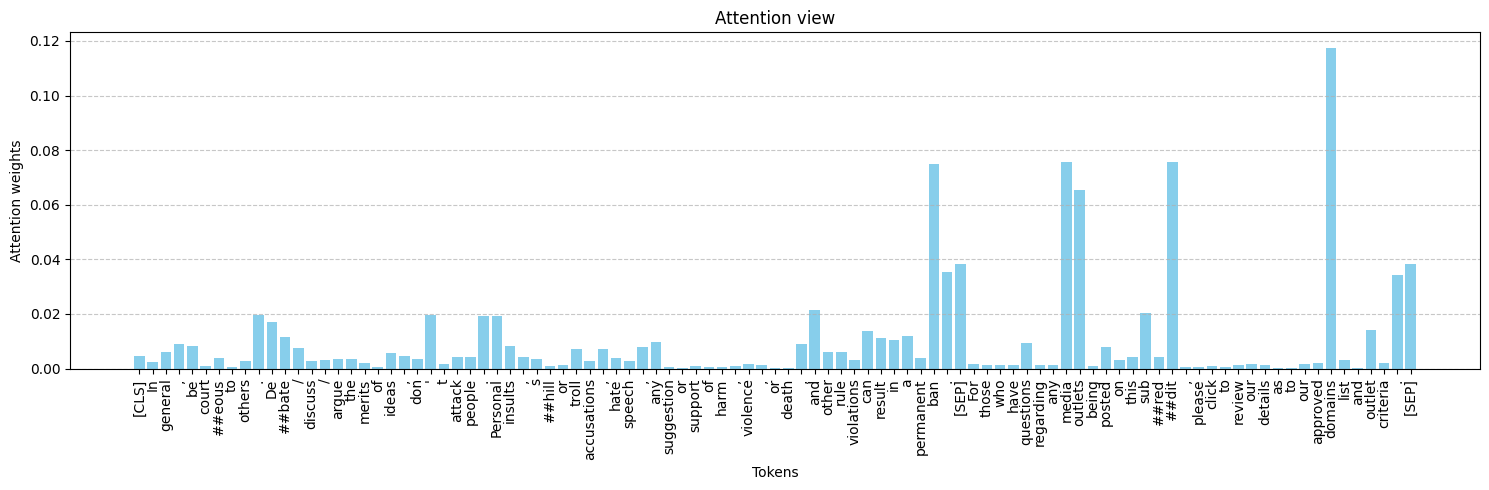

In [14]:
# True Negative
attention_views(sorted_idx[0], (15, 5))

True label: 0, classification probability: 0.9688178300857544
r / politics is currently accepting new moderator applications . If you want to help make this community a better place , consider !
In general , be courteous to others . Debate / discuss / argue the merits of ideas , don ' t attack people . Personal insults , shill or troll accusations , hate speech , any suggestion or support of harm , violence , or death , and other rule violations can result in a permanent ban .


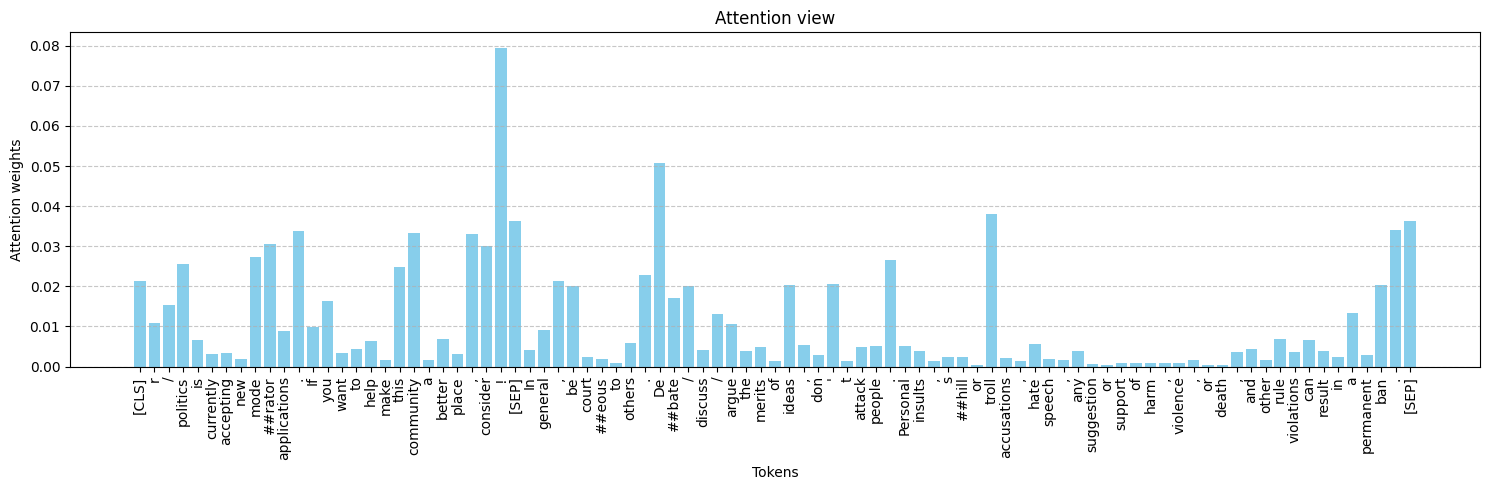

In [15]:
# True Negative
attention_views(sorted_idx[1], (15, 5))

True label: 0, classification probability: 0.0761571004986763
I am a bot , and this action was performed automatically . Please if you have any questions or concerns .
Are you trying to count interest from the fund ? You can ’ t balance the budget with that if the fund is being depleted because the interest goes away . Even if you did balance the budget with that , COLA is the highest it has been in decades , inflation fast outpacing the meager interest . We need a self - sustaining SSA and the only way to do that is to take in as much money as it disburses .


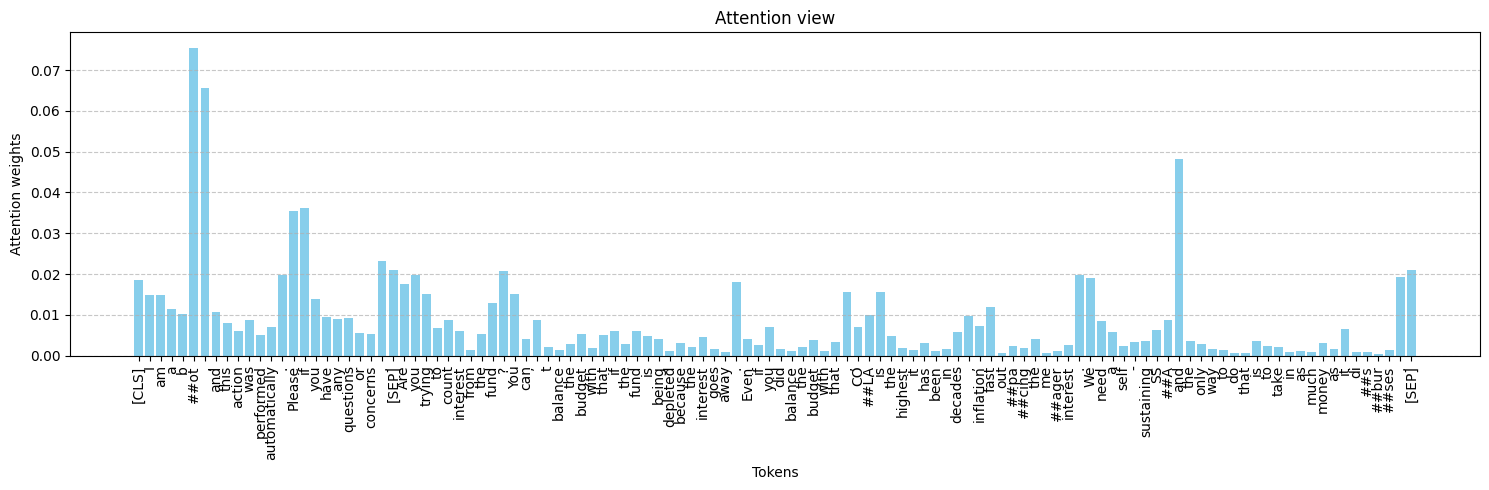

In [16]:
# False Positive
attention_views(sorted_idx[4001], (15, 5))

True label: 0, classification probability: 0.07595126330852509
Weirdly several states GOP embraced mail in voting , but now that they ' re seeing that it hurts them they are starting to roll it back . Same with Ranked Choice , they no longer support legislation for the public good , just to further their own control .
I am a bot , and this action was performed automatically . Please if you have any questions or concerns .


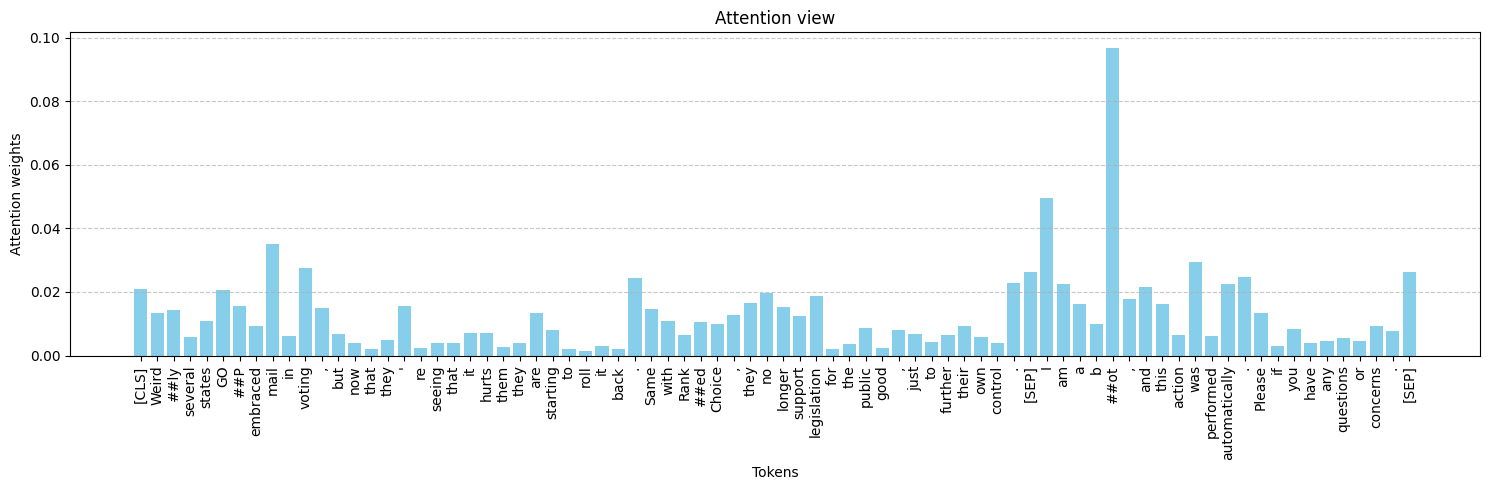

In [17]:
# False Positive
attention_views(sorted_idx[4003], (15, 5))

## 2. Different Author

True label: 1, classification probability: 0.9364453554153442
For those who have questions regarding any media outlets being posted on this subreddit , please click to review our details as to our approved domains list and outlet criteria .
Because when the Russians hacked the RNC they handed incriminating materials to Trump or someone in his circle . And he has been using those materials to make sure he : 1 ) maintains his wealth , 2 ) achieves his political aspirations , and 3 ) is never held accountable for any major crime . And for the most part it has worked .


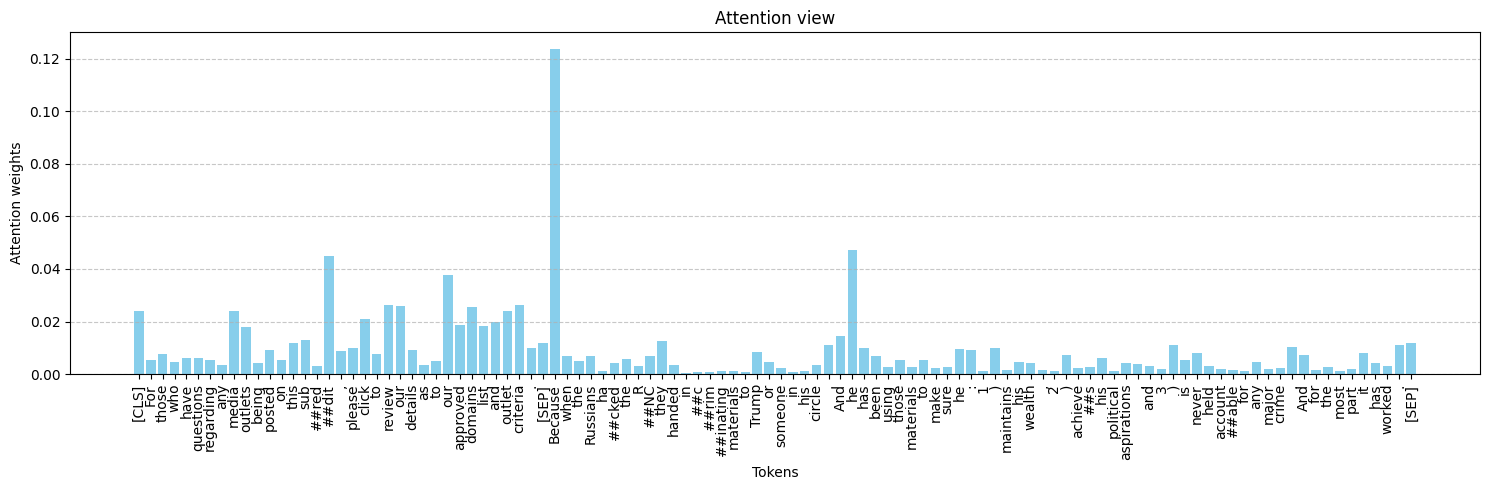

In [18]:
# True Positive
attention_views(sorted_idx[10], (15, 5))

True label: 1, classification probability: 0.9358569383621216
For those who have questions regarding any media outlets being posted on this subreddit , please click to review our details as to our approved domains list and outlet criteria .
We may share the same physical space and legal framework as conservatives but the two sides live in completely different worlds . One side believes in the myth of bipartisanship and respecting the rights of minorities and the other is one smart , charismatic leader away from becoming the Eden ' s Gate cult from Far Cry 5 . How do you govern a country where 30 % of the population believes they ' re in a holy war against literal demons ?


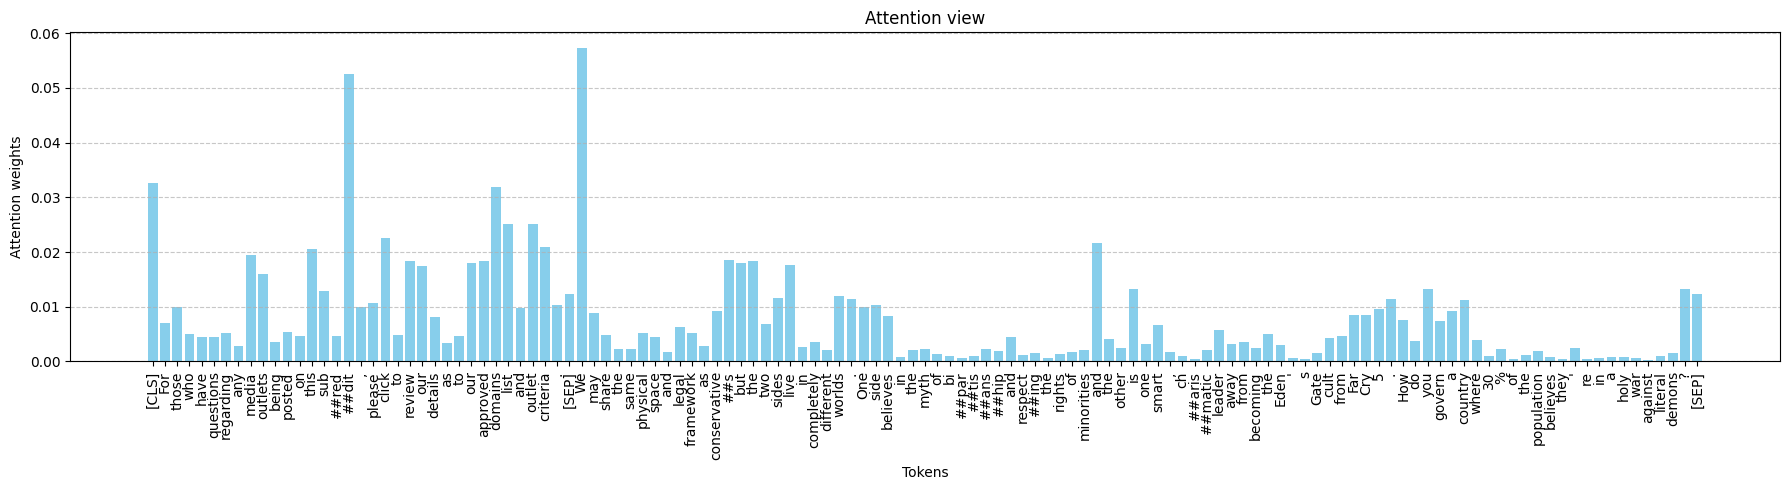

In [19]:
# True Positive
attention_views(sorted_idx[15], (18, 5))

True label: 1, classification probability: 0.06331285834312439
In general , be courteous to others . Debate / discuss / argue the merits of ideas , don ' t attack people . Personal insults , shill or troll accusations , hate speech , any suggestion or support of harm , violence , or death , and other rule violations can result in a permanent ban .
Your headline must be comprised only of the exact copied and pasted headline of the article - ) We recommend not using the Reddit ' suggest a title ' as it may not give the exact title of the article .


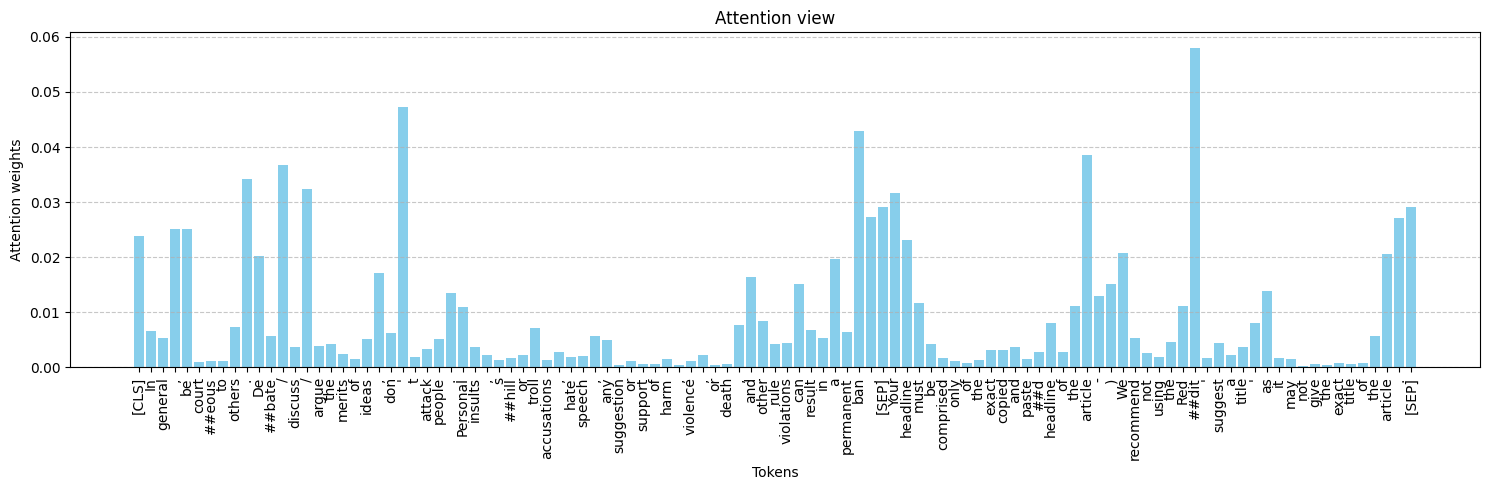

In [20]:
# False Negative
attention_views(sorted_idx[4028], (15, 5))

True label: 1, classification probability: 0.06691479682922363
In general , be courteous to others . Debate / discuss / argue the merits of ideas , don ' t attack people . Personal insults , shill or troll accusations , hate speech , any suggestion or support of harm , violence , or death , and other rule violations can result in a permanent ban .
Eliminate income cap on payroll taxes , raise the estate tax , eliminate carried interest and ETF loopholes .


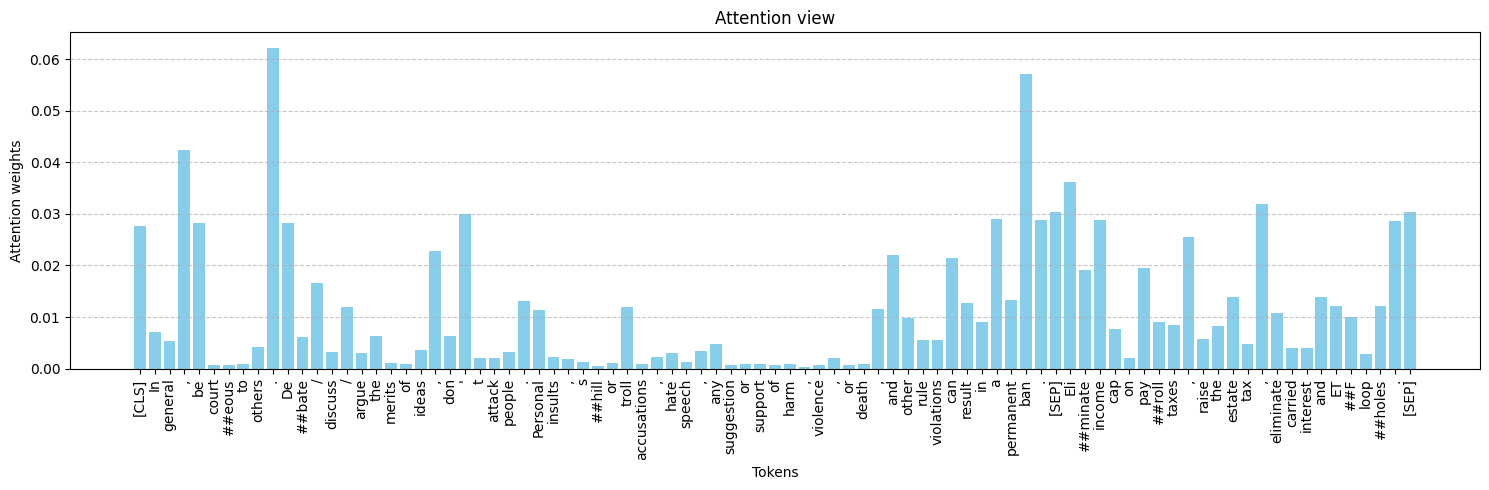

In [21]:
# False Negative
attention_views(sorted_idx[4026], (15, 5))

## More details

# Attention statistics

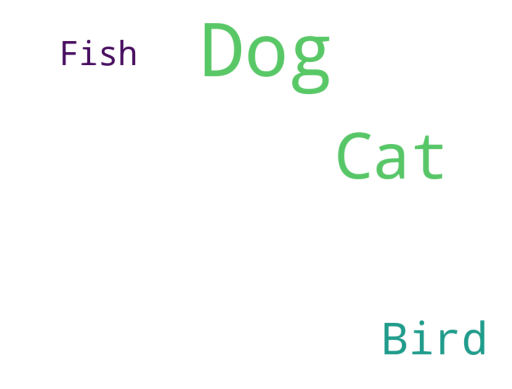

In [22]:
from wordcloud import WordCloud, STOPWORDS
word_freqs = {"Cat": 0.5, "Dog": 0.7, "Bird": 0.2, "Fish": 0.1}

def draw_word_cloud(word_freqs, width=800, height=600):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color='white', width=width, height=height,
                        stopwords=stopwords, max_font_size=120,
                        random_state=42)
    wordcloud.generate_from_frequencies(word_freqs)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

draw_word_cloud(word_freqs)


In [25]:
# Calculate the accumulated attention weights of each word in the True Positive samples, 
# the True Negative samples, the False Positive samples and the False Negative samples
from collections import defaultdict 
TP_word_attention = defaultdict(lambda: 0)
TN_word_attention = defaultdict(lambda: 0)
FP_word_attention = defaultdict(lambda: 0)
FN_word_attention = defaultdict(lambda: 0)
TP_word_count = defaultdict(lambda: 0)
TN_word_count = defaultdict(lambda: 0)
FP_word_count = defaultdict(lambda: 0)
FN_word_count = defaultdict(lambda: 0)

for i, idx in enumerate(sorted_idx):
    # input_texts = ["The cat sat on the mat" , "The cat sat on the mat" ]
    input_texts = [test_dataset['sentence1'][idx], test_dataset['sentence2'][idx]]
    label = test_dataset['label'][idx]
    inputs = tokenizer(input_texts[0], input_texts[1], return_tensors='pt')  # Tokenize input text
    inputs = {k:v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)  # Run model
    attention = outputs[-1][-1]  # Retrieve attention from model outputs, and select the attention of the last layer, torch.Size([1, 12, 8, 8])
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])  # Convert input ids to token strings
    # print(outputs['logits'], outputs['logits'].softmax(dim=1), label, outputs['logits'].softmax(dim=1)[0, label])
    target_prob = outputs['logits'].softmax(dim=1)[0, label]
    attention_score = torch.mean(attention[0,:,0,:], dim=0).cpu().detach().numpy()
    # print(target_prob, label, tokens)
    def record_attention(word_dic, word_counter, tokens, attention):
        for i, token in enumerate(tokens):
            word_dic[token] += attention[i]
            word_counter[token] += 1
            
    if target_prob > 0.5 and label == 1: # True Positive
        record_attention(TP_word_attention, TP_word_count, tokens, attention_score)
    elif target_prob > 0.5 and label == 0: # True Negative
        record_attention(TN_word_attention, TN_word_count, tokens, attention_score)
    elif target_prob <= 0.5 and label == 1: # False Negative
        record_attention(FN_word_attention, FN_word_count, tokens, attention_score)
    elif target_prob <= 0.5 and label == 0: # False Positive
        record_attention(FP_word_attention, FP_word_count, tokens, attention_score)

    
def normalize_attention(word_dic, word_counter):
    for k in word_dic:
        word_dic[k] /= word_counter[k]
normalize_attention(TP_word_attention, TP_word_count)
normalize_attention(TN_word_attention, TN_word_count)
normalize_attention(FN_word_attention, FN_word_count)
normalize_attention(FP_word_attention, FP_word_count)


In [26]:
def print_top_x(dic, top_x):
    # Sort the dictionary by values in descending order using a custom function
    sorted_dict = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))
    for i, key in enumerate(sorted_dict):
        print(key, '\t',sorted_dict[key])  
        if i >= top_x - 1:
            break

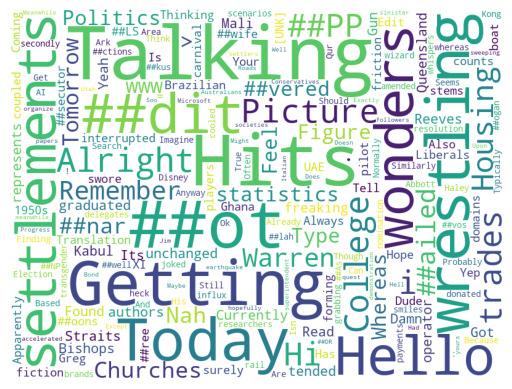

Talking 	 0.10856086574494839
Hits 	 0.10013249516487122
##ot 	 0.08484380784528418
Getting 	 0.07597542675212025
wrestling 	 0.07142792642116547
Today 	 0.06887761503458023
##dit 	 0.05806249010623985
settlements 	 0.057999007403850555
Hello 	 0.056947141885757446
wonders 	 0.055061887949705124
Alright 	 0.053999125957489014
College 	 0.05290183424949646
Picture 	 0.05264218896627426
Hi 	 0.05155688584116953
i 	 0.05151410380702665
##PP 	 0.05151168256998062
trades 	 0.05050104111433029
Housing 	 0.04749952256679535
Remember 	 0.04705889608400563
##ailed 	 0.04629525542259216


In [27]:
# detected authorship changing
draw_word_cloud(TP_word_attention) 
print_top_x(TP_word_attention, 20)


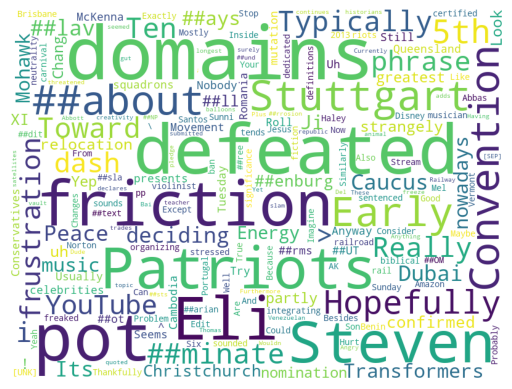

domains 	 0.11249464750289917
defeated 	 0.09334546327590942
pot 	 0.08697507530450821
friction 	 0.07684920728206635
Eli 	 0.06994479894638062
Patriots 	 0.06622524559497833
Steven 	 0.06574463658034801
Stuttgart 	 0.060651322826743126
##about 	 0.05930029973387718
Convention 	 0.05899876169860363
Early 	 0.05898304283618927
Hopefully 	 0.05543145537376404
5th 	 0.0552869588136673
Typically 	 0.0552588626742363
##minate 	 0.05524914711713791
Ten 	 0.05517232231795788
Toward 	 0.054659146815538406
> 	 0.05249573802575469
frustration 	 0.05213538836687803
phrase 	 0.05199195072054863


In [28]:
# detected authorship consistency
draw_word_cloud(TN_word_attention)
print_top_x(TN_word_attention, 20)

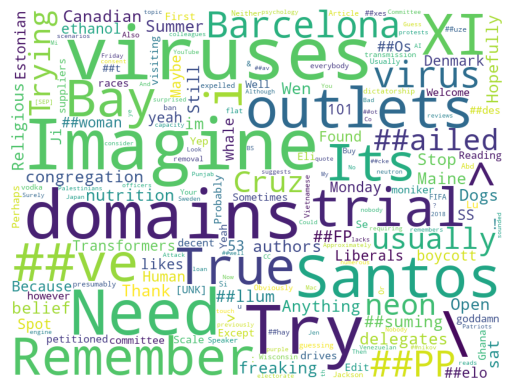

viruses 	 0.11442609131336212
Imagine 	 0.10423477366566658
Try 	 0.09474178403615952
domains 	 0.09370162338018417
\ 	 0.08292042836546898
Need 	 0.08184509724378586
Santos 	 0.06907875835895538
XI 	 0.06683187435070674
outlets 	 0.06294260174036026
trial 	 0.05788661539554596
##ve 	 0.0575383435934782
Remember 	 0.056507762521505356
^ 	 0.05491852015256882
Its 	 0.054259497486054895
True 	 0.05303273722529411
Bay 	 0.05261498689651489
i 	 0.05216780992729279
Barcelona 	 0.051378391683101654
virus 	 0.051309969276189804
##PP 	 0.05110085383057594


In [29]:
# undetected authorship changing
draw_word_cloud(FN_word_attention)
print_top_x(FN_word_attention, 20)

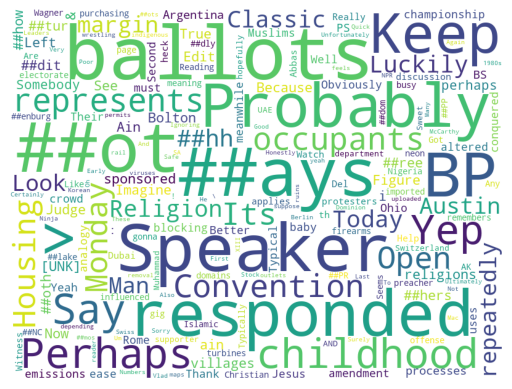

ballots 	 0.08698257803916931
##ot 	 0.07502712705314568
##ays 	 0.07114037871360779
Speaker 	 0.06916286051273346
responded 	 0.06395791657269001
> 	 0.06157092909727778
BP 	 0.05979768931865692
Probably 	 0.057940235982338585
Keep 	 0.05489775538444519
Perhaps 	 0.05436616390943527
Say 	 0.05390419811010361
childhood 	 0.052113838493824005
Yep 	 0.05167701840400696
represents 	 0.05083651840686798
Convention 	 0.049567557871341705
occupants 	 0.0491802953183651
Monday 	 0.04763188585639
Its 	 0.047081424455557554
Open 	 0.04701099544763565
Housing 	 0.04701025038957596


In [30]:
# undetected authorship consistency
draw_word_cloud(FP_word_attention)
print_top_x(FP_word_attention, 20)

In [31]:
# from bertviz import head_view

# idx = 1000
# # input_texts = ["The cat sat on the mat" , "The cat sat on the mat" ]
# input_texts = [test_dataset['sentence1'][idx], test_dataset['sentence2'][idx]]
# label = test_dataset['label'][idx]
# print(input_texts[0])
# print(input_texts[1])
# print(label)
# inputs = tokenizer(input_texts[0], input_texts[1], return_tensors='pt')  # Tokenize input text
# inputs = {k:v.to(device) for k, v in inputs.items()}
# outputs = model(**inputs)  # Run model
# attention = outputs[-1]
# tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])  # Convert input ids to token strings
# # print(outputs['logits'], outputs['logits'].softmax(dim=1), label, outputs['logits'].softmax(dim=1)[0, label])
# # target_prob = outputs['logits'].softmax(dim=1)[0, label]
# # attention_score = torch.mean(attention[0,:,0,:], dim=0).cpu().detach().numpy()

# head_view(attention, tokens) 